# Modifications

Link to Interactive Notebook: 
https://colab.research.google.com/drive/1sbJTsgCsAQwCkGdLXK7EdgkaTpiTGBM1#scrollTo=T71qxHyh9p23

1. Reduced Input Dimension
2. Different handling of xco2
3. Custom rmse function

What has helped the most?
- ELU
- ADAM
- MODEL Architecture

batch size?

In [1]:
import imp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import sys
import tensorflow as tf
from tensorflow import keras
import os
from sklearn.model_selection import train_test_split
tf.random.set_seed(42)


sys.path.insert(0, '../src')

from utils import df_to_xarray,read_xarray,inverse_scale_image, get_point_prediction

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/cfgrib_.py:27: UserWarning: Failed to load cfgrib - most likely there is a problem accessing the ecCodes library. Try `import cfgrib` to get the full error message
  warnings.warn(
2021-11-09 12:12:03.865782: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
# Reading Data
dir_name="../data/data1"
val_dir_name="../data/data2"

## Data Preprocessing

In [3]:
sys.path.insert(0, '../src/preprocess')

from data_preprocess import preprocess_images_nfp

X = preprocess_images_nfp(dir_name)
val_X = preprocess_images_nfp(val_dir_name)

/burg/glab/users/sk4973/venv/lib/python3.8/site-packages/xarray/backends/plugins.py:61: RuntimeWarning: Engine 'cfgrib' loading failed:
ecCodes library not found using ['eccodes', 'libeccodes.so', 'libeccodes']
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
INPUT_SHAPE=X[0].shape
OUTPUT_SHAPE=pco2_images[0].shape

INPUT_SHAPE

(180, 360, 5)

In [5]:
X.shape

(421, 180, 360, 5)

## Modeling

### Image Segmentation
CNN - Unet

Reference: 
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47


In [7]:
import tensorflow.keras.backend as kb
import tensorflow as tf
from tensorflow.keras import backend as K

def custom_rmse(y_true, y_pred):
    """
    custom_rmse(y_true, y_pred)
    calculates root square mean value with focusing only on the ocean
    """
    #y_pred = y_pred[y_true != 0]
    #y_true = y_true[y_true != 0]
    
    y_pred = tf.convert_to_tensor(y_pred)
    y_true = tf.cast(y_true, y_pred.dtype)
    
    return K.sqrt(K.mean(tf.math.squared_difference(y_pred, y_true), axis=-1))

### Base Model

In [123]:
tf.keras.backend.clear_session()

In [55]:
from functools import partial

## Experiment 1
## relu vs. elu
## elu headstart & more training allowed

## Experiment 2
## kernel intializer = "he_normal" -> does not work
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=5,activation='elu',
                        padding="SAME")


base_model = keras.models.Sequential([
    DefaultConv2D(filters=64, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3), #pool size 3 > pool size 2
    keras.layers.Dropout(0.3),# drop out at the end of the deepest

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),


    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),    
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])


## BEST SO FAR ##

base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 64)      8064      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 64)      102464    
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 64)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 128)      204928    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 128)      409728    
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 180, 360, 128)     0

In [56]:
myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
base_model.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [57]:
model_path="../models/base_model/base_model_new.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

#batch size 24, 32, 64 not as good
# batch size 16 the best
history = base_model.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)



Epoch 1/100
27/27 [==============================] - 6s 200ms/step - loss: 142.8320 - mean_squared_error: 163971.3784 - val_loss: 33.6630 - val_mean_squared_error: 1340.1407
Epoch 2/100
27/27 [==============================] - 5s 178ms/step - loss: 33.2313 - mean_squared_error: 1300.9619 - val_loss: 29.6193 - val_mean_squared_error: 1028.5386
Epoch 3/100
27/27 [==============================] - 5s 179ms/step - loss: 30.2870 - mean_squared_error: 1078.1862 - val_loss: 26.6017 - val_mean_squared_error: 842.6999
Epoch 4/100
27/27 [==============================] - 5s 179ms/step - loss: 27.0007 - mean_squared_error: 865.0901 - val_loss: 23.9602 - val_mean_squared_error: 685.6956
Epoch 5/100
27/27 [==============================] - 5s 178ms/step - loss: 23.3687 - mean_squared_error: 654.9329 - val_loss: 21.4146 - val_mean_squared_error: 556.3313
Epoch 6/100
27/27 [==============================] - 5s 179ms/step - loss: 21.6890 - mean_squared_error: 571.3622 - val_loss: 19.8010 - val_mean_sq

### Base Model Output

In [60]:

best_model = tf.keras.models.load_model('../models/base_model/base_model_new.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

1/1 [==============================] - 0s 72ms/step


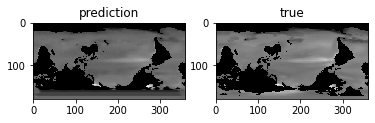

<Figure size 432x288 with 0 Axes>

In [61]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()
plt.savefig('base_model_prediction.png')

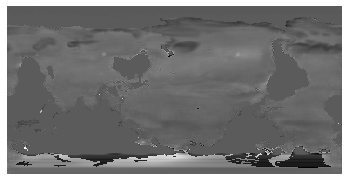

In [62]:
difference=np.squeeze(pco2_images[419:421][1])-np.squeeze(predicted_image[0])
plot_image(difference)

## Model 1

- more complex model with a greater parameters
- need a different learning rate

In [68]:

#kernel_size matters, 2 does not work

model1 = keras.models.Sequential([
    DefaultConv2D(filters=32, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.35),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.35),

    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

model1.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 40, 64)        0

In [69]:
myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
model1.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

In [70]:
model_path="../models/base_model/reduceddim_model1.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model1.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)




Epoch 1/100
27/27 [==============================] - 4s 139ms/step - loss: 89.2246 - mean_squared_error: 26146.0128 - val_loss: 43.2191 - val_mean_squared_error: 2075.2083
Epoch 2/100
27/27 [==============================] - 3s 117ms/step - loss: 40.3628 - mean_squared_error: 1797.9946 - val_loss: 33.7339 - val_mean_squared_error: 1313.3337
Epoch 3/100
27/27 [==============================] - 3s 117ms/step - loss: 33.6798 - mean_squared_error: 1313.2450 - val_loss: 32.1518 - val_mean_squared_error: 1198.2673
Epoch 4/100
27/27 [==============================] - 3s 117ms/step - loss: 31.4822 - mean_squared_error: 1153.4590 - val_loss: 28.5079 - val_mean_squared_error: 952.5831
Epoch 5/100
27/27 [==============================] - 3s 117ms/step - loss: 28.3888 - mean_squared_error: 941.0056 - val_loss: 25.5920 - val_mean_squared_error: 767.4824
Epoch 6/100
27/27 [==============================] - 3s 117ms/step - loss: 26.2227 - mean_squared_error: 802.9679 - val_loss: 24.8618 - val_mean_sq

In [11]:

best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model1.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 71ms/step


### Model 1 Result

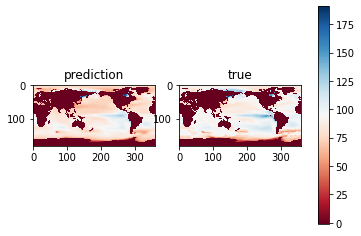

In [9]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


img=axis[0].imshow(np.flipud(np.squeeze(predicted_image[1])), cmap="RdBu", interpolation="nearest")
axis[0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[1].imshow(np.flipud(np.squeeze(pco2_images[419:421][1])), cmap="RdBu", interpolation="nearest")
axis[1].set_title("true")
plt.show()



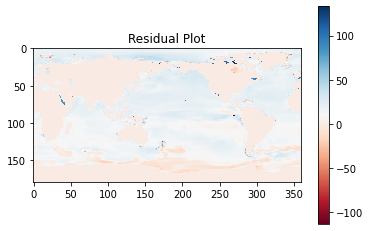

In [10]:
diff=np.flipud(np.squeeze(pco2_images[419:421][1]-predicted_image[1]))
plt.imshow(diff,cmap="RdBu", interpolation="nearest")
plt.colorbar()
plt.title("Residual Plot")

plt.show()

In [67]:
# Over time

rmses = []

for i in range(421):    
    rmse = np.sqrt(np.mean((pco2_images[i]-predicted_image)**2))
    rmses.append(rmse)

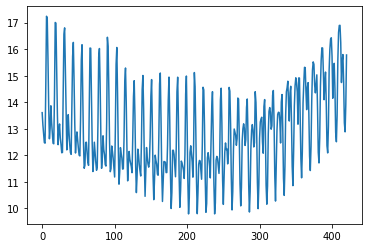

In [63]:
plt.plot(rmses)
plt.savefig('../assets/overtime.png')



## Model 2
- slightly deeper and more complex

Definitely does not like complex models
filter > 128 : lost cause

In [124]:
model2 = keras.models.Sequential([
    DefaultConv2D(filters=16, input_shape=INPUT_SHAPE),
    DefaultConv2D(filters=16),
    keras.layers.MaxPooling2D(pool_size=3),
    keras.layers.Dropout(0.35),

    DefaultConv2D(filters=32),
    DefaultConv2D(filters=32),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.35),

    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dropout(0.35),
    
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),

    keras.layers.UpSampling2D(size=2),
    DefaultConv2D(filters=64),
    DefaultConv2D(filters=64),
    
    keras.layers.UpSampling2D(size=2),
    DefaultConv2D(filters=32),
    DefaultConv2D(filters=32),

    keras.layers.UpSampling2D(size=3),
    DefaultConv2D(filters=16),
    DefaultConv2D(filters=2),
    DefaultConv2D(filters=1,kernel_size=1),
    keras.layers.Reshape(OUTPUT_SHAPE)
   
])

model2.summary()

myLearnRate=0.001
custom_opt = tf.keras.optimizers.Adam(learning_rate=myLearnRate)
model2.compile(loss=custom_rmse, optimizer=custom_opt, metrics=["mean_squared_error"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 180, 360, 32)      4032      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 360, 32)      25632     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 120, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 60, 120, 32)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 120, 64)       51264     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 60, 120, 64)       102464    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 60, 64)        0

In [ ]:
model_path="../models/base_model/reduceddim_model2.h5"
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=7, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint]

history = model2.fit(X,pco2_images, epochs=100, validation_data=(X,pco2_images),workers=-1,batch_size=16,callbacks=callbacks)


In [9]:
best_model = tf.keras.models.load_model('../models/base_model/reduceddim_model2.h5', custom_objects={'custom_rmse':custom_rmse})
predicted_image=best_model.predict(X[419:421],verbose=1)

2021-11-02 10:16:52.539243: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-02 10:16:53.233311: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2021-11-02 10:16:53.282198: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-02 10:16:53.299813: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (g058): /proc/driver/nvidia/version does not exist
2021-11-02 10:16:54.150887: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical 

1/1 [==============================] - 13s 13s/step


### Model 2 Result

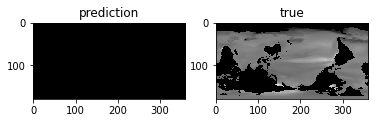

In [10]:
import matplotlib.pyplot as plt

figure, axis = plt.subplots(1, 2)


axis[0].imshow(np.squeeze(predicted_image[1]), cmap="gray", interpolation="nearest")
axis[0].set_title("prediction")
axis[1].imshow(np.squeeze(pco2_images[419:421][1]), cmap="gray", interpolation="nearest")
axis[1].set_title("true")

plt.show()

## Testing Generalization Capability

Using Validation data of other dataset

In [12]:
val_dir_name="../data/data2"

X, pco2_images = preprocess_images(val_dir_name)

In [13]:
predicted_image=best_model.predict(X,verbose=1)

14/14 [==============================] - 1s 70ms/step


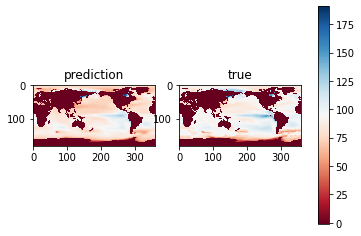

In [17]:
figure, axis = plt.subplots(1, 2)



img=axis[0].imshow(np.flipud(np.squeeze(predicted_image[1])), cmap="RdBu", interpolation="nearest")
axis[0].set_title("prediction")
plt.colorbar(img,ax=axis)

img1=axis[1].imshow(np.flipud(np.squeeze(pco2_images[419:421][1])), cmap="RdBu", interpolation="nearest")
axis[1].set_title("true")
plt.savefig('../assets/comparison.png')
plt.show()



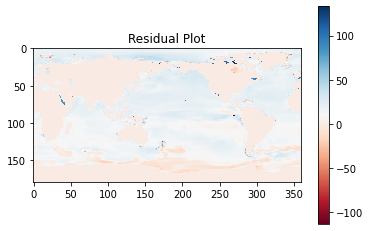

In [15]:
diff=np.flipud(np.squeeze(pco2_images[419:421][1]-predicted_image[1]))
plt.imshow(diff,cmap="RdBu", interpolation="nearest")
plt.colorbar()
plt.title("Residual Plot")

plt.savefig('../assets/residual.png')
plt.show()

In [18]:
print("RMSE score!")
np.sqrt(np.mean((predicted_image-pco2_images)**2))
# generalization works pretty well

RMSE score!


6.665529530011642

## Getting PCO2 Prediction per Point

In [21]:
chl,mld,sss,sst,u10,fg_co2,xco2,icefrac,patm,pco2 = read_xarray(val_dir_name)
actual=inverse_scale_image(predicted_image,pco2.pCO2.data)  

In [94]:
print(get_point_prediction(actual[0],100,100))
print(get_point_prediction(pco2.pCO2.data[0],100,100))

311.42273
283.1524633156878


In [109]:
print("Scaled back RMSE score:")
np.sqrt(np.mean((pco2.pCO2.data-actual)**2))

Scaled back RMSE score:


18.921340052638598

In [110]:
#pco2 data information
print("mean:",np.mean(pco2.pCO2.data[0]))
print("min:",np.min(pco2.pCO2.data[0]))
print("max:",np.max(pco2.pCO2.data[0]))
print("std:",np.std(pco2.pCO2.data[0]))

mean: 243.422023630907
min: 107.25041201956655
max: 561.4547637325538
std: 108.200971868547
